# **Physics-based loss and machine learing approach in application to fluids flow modelling: 3D flow in a pipe**
It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. 



# Initialization
## Import libraries

In [1]:
# Pytorch modules
import torch
from torch import nn

# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict

# Status bar
from tqdm.notebook import tqdm
from datetime import datetime
import time

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image

#Log
import neptune.new as neptune
from neptune.new.types import File

import time

## Neptune project

In [2]:
run = neptune.init(
    project="avkornaev/PhysicsBasedDL",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRjMGY4Ny1hYTI1LTQxZmEtYjRmZC02YzNkYWZjYzNiNjIifQ==",
)  # your credentials

C:\Users\IMS\AppData\Local\Temp\ipykernel_25412\2958366738.py:1: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  run = neptune.init(


https://app.neptune.ai/avkornaev/PhysicsBasedDL/e/PHYSIC-242
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Download and preprocess image of the flow domain

## Path

In [3]:
path =  Path('./')
imgPath = path/'ToyDataset'
imgList = fnmatch.filter(os.listdir(imgPath), '*.pt') #imgPath.ls()
imgList
#Image number from the imgList
imgNo = 0
print(imgList, imgNo)

['pipe_tensor.pt'] 0


Download 3D image

In [4]:
img = torch.load(os.path.join(imgPath, imgList[imgNo]))
imgDim = img.shape[1:]
print(f'image shape: {imgDim}')

image shape: torch.Size([128, 128, 128])


## Constants

In [5]:
SIZE = imgDim
#Training
EPOCHS = 60000
NoOfFeatures = 32 #32
WORK_DIR = '/root/Physics_based_loss'
IN_CH = 1 #number of input channels
OUT_CH = 1#number of output channels
#Loss regularization
REG_LOSS_COEF = 1000000

#SCALE_FACTOR = 1 # muliplier for the loss function
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "unet"
EARLY_STOP_PATIENCE = EPOCHS
DECAY = 1e-4
PATIENCE = 0

parameters = {'image_size':SIZE,
             'Epochs':EPOCHS,
             'Model':MODEL_NAME,
             'No_of_features':NoOfFeatures}

HYPS = []

hyps = {"Epochs":[EPOCHS],
        "learning_rate": [1e-4],
        "scheduler": ["none"],
        "scheduler_factor": [0.5],
        "scheduler_patience": [int(EPOCHS*0.05)],
        "use_bn": [True],
        "Early_stop_patience": [EARLY_STOP_PATIENCE],
        "Decay": [DECAY]} # Use or not batchnorm
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})

#Visualization
STEP3D = 8
slices = [int(imgDim[0]/2), int(imgDim[1]/2), int(imgDim[2]/2)]
vps = 10 #vector plot step 
FIGSIZE = 5 # figure size

## Log parameters

In [6]:
run["config/parameters"] = parameters
run["config/hyperparameters"] = hyps

C:\Users\IMS\anaconda3\envs\Pytorch\lib\site-packages\neptune\new\attributes\attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)


## Geometry of the flow domain, fluid properties and boundary conditions

Geometry

It is convenient to present the flow domain $\Omega$ in the form of a parallelepiped $x_i^- < x_i < x_i^+$ ($\boldsymbol{L} = [l_i] = [x_i^+ - x_i^-]$, $i = 1,2,3$).

In [7]:
# L_1 x L_2 x L_3 flow domain
L = [0.008, 0.008, 0.52]#, [m]
R = L[0]/4 #, [m]

# Normalized coordinates, normalized finite diferences, limits and elementary volume
X1N = torch.linspace(0, 1, SIZE[0])
X2N = torch.linspace(0, 1, SIZE[1])
X3N = torch.linspace(0, 1, SIZE[2])

DX1N = X1N[1] - X1N[0]
DX2N = X2N[1] - X2N[0]
DX3N = X3N[1] - X3N[0]

LIM1 = [0, L[0]]
LIM2 = [0, L[1]]
LIM3 = [0, L[2]]

dOmega = DX1N * DX2N * DX3N * L[0] * L[1] * L[2] # elementary volume

Boundary conditions
1. The values of the flow rates $Q_i(x_i^-)$, $Q_i(x_i^+)$ through the edges $x_i = x_i^-$, $x_i = x_i^+$ of the flow domain are given:

In [8]:
#Flow rates Q1-,Q2-,Q3-
Qm = [0, 0, -3E-6]

#Flow rates Q1+,Q2+,Q3+
Qp = [0, 0, 3E-6]

2. NL layers have fixed values of the unknown function $\boldsymbol\Psi$.

In [9]:
DVTEMP = 'sc' #template for the velocity function differentiation
if  DVTEMP == 'sc':
    NL = 3 + 5
elif DVTEMP == 'fc':
    NL = 5 + 5

Properties of non-Newtonian fluid and walls that are relatively rigid body.
The Herschel-Bulkley law is applied:
\begin{equation}
    \mu(H)=q_0+q_1H^{z-1},
\end{equation}
where $q_0$, $q_1$, $z$ are the parameters obtained from rheological tests.

In [10]:
#Non-Newtonian fluid viscosity
Q0 = 4e-3
Q1 = 0
Z = 1
# Fluid density, kg/m**3
RHO = 1000
#Newtonian fluid analogue
MU = Q0

#Critical Reynolds number
Re_cr = 1100

#Walls viscosity
Q0W = 1e+0#1e-0#1e+3eye 
Q1W = 0#1e-0
ZW =1#0.5

## Additional functions

3D numerical derivative

In [11]:
def num_diff(f,dx1,dx2,dx3,template='sc'):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2,
    k - index along x_3.
    '''
    #Shape
    n1, n2, n3 = f.shape
    
    df_dx1, df_dx2, df_dx3 = torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        df_dx3 = df_dx3.to('cuda')
    
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:,:] = (f[2:,:,:] - f[:-2,:,:]) / (2 * dx1)
        df_dx1[0,:,:] = (-f[2,:,:] + 4 * f[1,:,:] - 3 * f[0,:,:]) / (2 * dx1)
        df_dx1[n1-1,:,:] = (3 * f[n1-1,:,:] - 4 * f[n1-2,:,:] + f[n1-3,:,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1, :] = (f[:, 2:, :] - f[:, :-2, :]) / (2 * dx2)
        df_dx2[:,0, :] = (- f[:,2,:] + 4 * f[:,1,:] - 3 * f[:, 0, :]) / (2 * dx2)
        df_dx2[:,n2-1, :] = (3 * f[:, n2 - 1, :] - 4 * f[:, n2 - 2, :] + f[:, n2 - 3, :]) / (2 * dx2)
        # x3 derivative:
        df_dx3[:, :, 1:n3-1] = (f[:,:,2:] - f[:,:,:-2]) / (2 * dx3)
        df_dx3[:, :, 0] = (- f[:, :, 2] + 4 * f[:, :, 1] - 3 * f[:, :, 0]) / (2 * dx3)
        df_dx3[:, :, n3-1] = (3 * f[:, :, n3 - 1] - 4 * f[:, :, n3 - 2] + f[:, :, n3 - 3]) / (2 * dx3)
    elif template == 'fc':
        # x1 derivative
        df_dx1[2:n1-2, :, :] = (-f[4:, :,:] + 8 * f[3:n1-1, :, :] - 8 * f[1:n1-3, :, :] + f[:n1-4, :, :]) / (12 * dx1)
        df_dx1[0, :, :] = (-3 * f[4, :, :] + 16 * f[3, :, :] - 36 * f[2, :, :] + 48 * f[1, :,:] - 25 * f[0, :, :]) / (12 * dx1)
        df_dx1[1, :, :] = (f[4, :, :] - 6 * f[3, :, :] + 18 * f[2, :, :] - 10 * f[1, :, :] - 3 * f[0, :, :]) / (12 * dx1)
        df_dx1[n1-2, :, :] = (3 * f[n1-1, :, :] + 10 * f[n1-2, :, :] - 18 * f[n1-3, :, :] + 6 * f[n1-4, :, :] - f[n1-5, :, :]) / (12 * dx1)
        df_dx1[n1-1, :, :] = (25 * f[n1-1, :, :] - 48 * f[n1-2, :, :] + 36 * f[n1-3, :, :] - 16 * f[n1-4, :, :] + 3*f[n1-5, :, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2, :] = (-f[:, 4:, :] + 8 * f[:, 3:n2-1, :] - 8 * f[:, 1:n2-3, :] + f[:, :n2-4, :]) / (12 * dx2)
        df_dx2[:, 0, :] = (-3 * f[:,4, :] + 16 * f[:, 3, :] - 36 * f[:, 2, :] + 48 * f[:, 1, :] - 25 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, 1, :] = (f[:, 4, :] - 6 * f[:, 3, :] + 18 * f[:, 2, :] - 10 * f[:, 1, :] - 3 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, n2-2, :] = (3 * f[:, n2-1, :] + 10 * f[:, n2-2, :] - 18 * f[:, n2-3, :] + 6 * f[:, n2-4, :] - f[:, n2-5, :]) / (12*dx2)
        df_dx2[:, n2-1, :] = (25 * f[:, n2-1, :] - 48 * f[:, n2-2, :] + 36 * f[:, n2-3, :] - 16 * f[:, n2-4, :] + 3 * f[:,n2-5, :]) / (12*dx2)       
        # x3 derivative
        df_dx3[:, :, 2:n3-2] = (-f[:, :, 4:] + 8 * f[:, :, 3:n3-1] - 8 * f[:, :, 1:n3-3] + f[:, :, :n3-4]) / (12 * dx3)
        df_dx3[:, :, 0] = (-3 * f[:, :, 4] + 16 * f[:, :, 3] - 36 * f[:, :, 2] + 48 * f[:, :, 1] - 25 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, 1] = (f[:, :, 4] - 6 * f[:, :, 3] + 18 * f[:, :, 2] - 10 * f[:, :, 1] - 3 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, n3-2] = (3 * f[:, :, n3-1] + 10 * f[:, :, n3-2] - 18 * f[:, :, n3-3] + 6 * f[:,:,n3-4] - f[:, :, n3-5]) / (12 * dx3)
        df_dx3[:, :, n3-1] = (25 * f[:,:, n3-1] - 48 * f[:,:, n3-2] + 36 * f[:,:, n3-3] - 16 * f[:,:, n3-4] + 3*f[:,:, n3-5]) / (12 * dx3)
    
    return df_dx1, df_dx2, df_dx3

2D numerical derivative

In [12]:
def num_diff2D(f,dx1,dx2,template=DVTEMP):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2.
    '''
    #Shape
    n1, n2 = f.shape
    
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
            
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:] = (f[2:,:] - f[:-2,:]) / (2 * dx1)
        df_dx1[0,:] = (-f[2,:] + 4 * f[1,:] - 3 * f[0,:]) / (2 * dx1)
        df_dx1[n1-1,:] = (3 * f[n1-1,:] - 4 * f[n1-2,:] + f[n1-3,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx2)
        df_dx2[:,0] = (- f[:,2] + 4 * f[:,1] - 3 * f[:, 0]) / (2 * dx2)
        df_dx2[:,n2-1] = (3 * f[:, n2 - 1] - 4 * f[:, n2 - 2] + f[:, n2 - 3]) / (2 * dx2)
    elif template == 'fc':
        # 1st order x1 derivative:
        # x1 derivative
        df_dx1[2:n1-2, :] = (-f[4:, :] + 8 * f[3:n1-1, :] - 8 * f[1:n1-3, :] + f[:n1-4, :]) / (12 * dx1)
        df_dx1[0, :] = (-3 * f[4, :] + 16 * f[3, :] - 36 * f[2, :] + 48 * f[1, :] - 25 * f[0, :]) / (12 * dx1)
        df_dx1[1, :] = (f[4, :] - 6 * f[3, :] + 18 * f[2, :] - 10 * f[1, :] - 3 * f[0, :]) / (12 * dx1)
        df_dx1[n1-2, :] = (3 * f[n1-1, :] + 10 * f[n1-2, :] - 18 * f[n1-3, :] + 6 * f[n1-4, :] - f[n1-5, :]) / (12 * dx1)
        df_dx1[n1-1, :] = (25 * f[n1-1, :] - 48 * f[n1-2, :] + 36 * f[n1-3, :] - 16 * f[n1-4, :] + 3*f[n1-5, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2] = (-f[:, 4:] + 8 * f[:, 3:n2-1] - 8 * f[:, 1:n2-3] + f[:, :n2-4]) / (12 * dx2)
        df_dx2[:, 0] = (-3 * f[:,4] + 16 * f[:, 3] - 36 * f[:, 2] + 48 * f[:, 1] - 25 * f[:, 0]) / (12*dx2)
        df_dx2[:, 1] = (f[:, 4] - 6 * f[:, 3] + 18 * f[:, 2] - 10 * f[:, 1] - 3 * f[:, 0]) / (12*dx2)
        df_dx2[:, n2-2] = (3 * f[:, n2-1] + 10 * f[:, n2-2] - 18 * f[:, n2-3] + 6 * f[:, n2-4] - f[:, n2-5]) / (12*dx2)
        df_dx2[:, n2-1] = (25 * f[:, n2-1] - 48 * f[:, n2-2] + 36 * f[:, n2-3] - 16 * f[:, n2-4] + 3 * f[:,n2-5]) / (12*dx2)    
    
    return df_dx1, df_dx2

3D numerical integration (Simpson method)

In [13]:
def int_func_simpson_3d(f, dx, dy, dz):
  '''
  f - 3d-dimentional tensor
  dx, dy, dz - constant step along the corresponding coordinate
  '''
  n1,n2,n3 = f.shape
  # integrate by dz:
  if n3%2 == 0:
    J3 = (f[:,:,0:n3-2:2] + 4*f[:,:,1:n3-2:2] + f[:,:,2::2]).sum(dim=2)*dz/3 + (f[:,:,-1]+f[:,:,-2])*dz/2
  else:
    J3 = (f[:,:,0:n3-1:2] + 4*f[:,:,1:n3-1:2] + f[:,:,2::2]).sum(dim=2)*dz/3

  # integrate by dy:
  if n2%2 == 0:
    J2 = (J3[:,0:n2-2:2] + 4*J3[:,1:n2-2:2] + J3[:,2::2]).sum(dim=1)*dy/3 + (J3[:,-1]+J3[:,-2])*dy/2
  else:
    J2 = (J3[:,0:n2-1:2] +4 *J3[:,1:n2-1:2] + J3[:,2::2]).sum(dim=1)*dy/3

  # integrate by dx:
  if n1%2 == 0:
    J1 = (J2[0:n1-2:2] + 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
  else:
    J1 = (J2[0:n1-1:2] + 4*J2[1:n1-1:2] + J2[2::2]).sum(dim=0)*dx/3

  return J1

2D numerical integration (Simpson method)

In [14]:
def int_func_simpson_2d(f, dx, dy):
  '''
  f - 2d-dimentional tensor
  dx, dy - constant step along the corresponding coordinate
  '''
  n1, n2 = f.shape
  # integrate by dy:
  if n2%2 == 0:
    J2 = (f[:,0:n2-2:2]+ 4*f[:,1:n2-2:2] + f[:,2::2]).sum(dim=1)*dy/3 + (f[:,-1]+f[:,-2])*dy/2
  else:
    J2 = (f[:,0:n2-1:2] +4*f[:,1:n2-1:2]+f[:,2::2]).sum(dim=1)*dy/3
  # integrate by dx:
  if n1%2 == 0:
    J1 = (J2[0:n1-2:2]+ 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
  else:
    J1 = (J2[0:n1-1:2] +4*J2[1:n1-1:2]+J2[2::2]).sum(dim=0)*dx/3
  return J1

Visualization

In [15]:
def vector_plot(x, y, u, v, FIGSIZE, vptitle='vector_plot', xlabel='$x_i$', ylabel='$x_j$',step=10):
    gradmag = np.sqrt(u**2 + v**2)
    plt.pcolor(x, y, gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(x[::step,::step], y[::step,::step], u[::step,::step], v[::step,::step])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(vptitle)

In [16]:
def vector_plot_3d(x, v, v_abs, figSize=FIGSIZE, step=1, use_color=False):
    fig = plt.figure(figsize=(figSize, figSize))
    ax = fig.add_subplot(projection='3d')
    
    norm = plt.Normalize()
    colors = plt.cm.jet(norm(v_abs[::step, ::step, ::step]))

    pos = np.where(img[0].rot90().cpu().detach()==1)
    ax.scatter(pos[1], pos[0], pos[2], c='red', s=0.1, alpha=0.2)
    ax.quiver(x[0], x[1], x[2], v[::step, ::step, ::step, 0],
              v[::step, ::step, ::step, 1],
              v[::step, ::step, ::step, 2],
              color=colors.reshape(-1, 4) if use_color else 'b', length=20, normalize=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.bar3d(0, 0, 0., SIZE[0], SIZE[1], SIZE[2], alpha=0.1, edgecolor='black', color='black')
    plt.show()

In [17]:
def flowVisualization(psi,step=15,slices=slices):
    nr=2
    nc=len(SIZE)
    
    #Velocity distribution
    v1, v2, v3 = velocityDistr(psi[0,0,:,:].to('cpu'), psi[0,1,:,:].to('cpu'), psi[0,2,:,:].to('cpu'),
                               DX1N.to('cpu'), DX2N.to('cpu'), DX3N.to('cpu'),
                               L[0], L[1], L[2])
    V = torch.stack([v1.to('cpu'),v2.to('cpu'),v3.to('cpu')])
    Vabs = torch.sqrt(v1.to('cpu')**2 + v2.to('cpu')**2 + v3.to('cpu')**2)
    
    print('Psi function Visualization')
    fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    for i in range(len(SIZE)):
        plt.subplot(nr,nc,i+1)
        plt.imshow(psi[0,i,::].to('cpu'))
        plt.title(f'$\psi_{i+1}$')
        plt.subplot(nr,nc,i+1+nc)
        plt.plot(psi[0,i,:,slices[i]].to('cpu'))
        plt.grid()
    plt.show()
    
    print(f'Q1+ = {- (psi[0,1,-1,-1] - psi[0,1,-1,0])*L[1] + (psi[0,2,-1,-1] - psi[0,2,-1,0])*L[2]}, target value: {Qp[0]},')
    print(f'Q2+ = {- (psi[0,2,-1,-1] - psi[0,2,0,-1])*L[2] + (psi[0,0,-1,-1] - psi[0,0,-1,0])*L[0]}, target value: {Qp[1]},')
    print(f'Q3+ = {- (psi[0,0,-1,-1] - psi[0,0,0,-1])*L[0] + (psi[0,1,-1,-1] - psi[0,1,0,-1])*L[1]}, target value: {Qp[2]}')
    
    print()
    print('Velocity distribution visualization without flow domain mask (first line) and with mask (second line)')

    XN = torch.meshgrid(X1N,X2N,X3N)
    
    fig1 = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    #without flow domain mask 
    plt.subplot(nr,nc,1)
    vector_plot(XN[1][slices[0],:,:], XN[2][slices[0],:,:], V[1,slices[0],:,:], V[2,slices[0],:,:],
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,2)
    vector_plot(XN[0][:,slices[1],:], XN[2][:,slices[1],:], V[0,:,slices[1],:], V[2,:,slices[1],:],
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,3)
    vector_plot(XN[0][:,:,slices[2]], XN[1][:,:,slices[2]], V[0,:,:,slices[2]], V[1,:,:,slices[2]],
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    #with flow domain mask 
    plt.subplot(nr,nc,4)
    vector_plot(XN[1][0,:,:], XN[2][0,:,:], V[1,slices[0],:,:]*img[0,slices[0],:,:].to('cpu'), V[2,slices[0],:,:]*img[0,slices[0],:,:].to('cpu'),
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,5)
    vector_plot(XN[0][:,0,:], XN[2][:,0,:], V[0,:,slices[1],:]*img[0,:,slices[1],:].to('cpu'), V[2,:,slices[1],:]*img[0,:,slices[1],:].to('cpu'),
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,6)
    vector_plot(XN[0][:,:,0], XN[1][:,:,0], V[0,:,:,slices[2]]*img[0,:,:,slices[2]].to('cpu'), V[1,:,:,slices[2]]*img[0,:,:,slices[2]].to('cpu'),
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    
    #Check the flow rates Q3-,Q3+
    Q1mch = int_func_simpson_2d(V[0, 0, :, :], L[1]*DX2N.to('cpu'), L[2]*DX3N.to('cpu'))
    Q1pch = int_func_simpson_2d(V[0,-1, :, :], L[1]*DX2N.to('cpu'), L[2]*DX3N.to('cpu'))
    
    Q2mch = int_func_simpson_2d(V[1, :, 0, :], L[0]*DX1N.to('cpu'), L[2]*DX3N.to('cpu'))
    Q2pch = int_func_simpson_2d(V[1, :,-1, :], L[0]*DX1N.to('cpu'), L[2]*DX3N.to('cpu'))
    
    Q3mch = int_func_simpson_2d(V[2, :, :, 0], L[0]*DX1N.to('cpu'), L[1]*DX2N.to('cpu'))
    Q3pch = int_func_simpson_2d(V[2, :, :,-1], L[0]*DX1N.to('cpu'), L[1]*DX2N.to('cpu'))
    
    print(f'{V[0].min()} < v_1 < {V[0].max()},')
    print(f'{V[1].min()} < v_2 < {V[1].max()},')
    print(f'{V[2].min()} < v_3 < {V[2].max()},')
    print(f'Q1- = {Q1mch}, Q1+ = {Q1pch}')
    print(f'Q2- = {Q2mch}, Q2+ = {Q2pch}')
    print(f'Q3- = {Q3mch}, Q3+ = {Q3pch}')
    
    print(f'Vabs[0,0,0] = {Vabs[0,0,0]}, Vabs[0,0,-1] = {Vabs[0,0,-1]}, Vabs[0,-1,0] = {Vabs[0,-1,0]}, Vabs[0,-1,-1] = {Vabs[0,-1,-1]}, Vabs[-1,0,0] = {Vabs[-1,0,0]}, Vabs[-1,0,-1] = {Vabs[-1,0,-1]}, Vabs[-1,-1,0] = {Vabs[-1,-1,0]}, Vabs[-1,-1,-1] = {Vabs[-1,-1,-1]},')
  
    return 

## Major functions

For any given function $\boldsymbol\Psi = [\psi_i]$ that has fixed values on the boundaries of the flow domain together with its first, second, and third derivatives, the velocity distribution can be expressed in compact or in expanded form, respectively:
\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \epsilon_{ijk}
    \frac{\partial \psi_k(x_i,x_j)}{\partial x_j}
    \end{bmatrix},
\end{equation}
where $\epsilon_{ijk}$ is the Levi-Civita symbol,

\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \frac{\partial \psi_3}{\partial x_2} - \frac{\partial \psi_2}{\partial x_3}, &
    \frac{\partial \psi_1}{\partial x_3} - \frac{\partial \psi_3}{\partial x_1}, &
    \frac{\partial \psi_2}{\partial x_1} - \frac{\partial \psi_1}{\partial x_2}
    \end{bmatrix}.
\end{equation} 

In [18]:
def velocityDistr(psi1,psi2,psi3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    '''Velocity distribution [v_i] in the flow domain
    '''
    
    #Psi function and it's partial derivatives are 2D functions
    dpsi1dx2, dpsi1dx3 = num_diff2D(psi1, dx2n, dx3n)
    dpsi2dx1, dpsi2dx3 = num_diff2D(psi2, dx1n, dx3n)
    dpsi3dx1, dpsi3dx2 = num_diff2D(psi3, dx1n, dx2n)
    
    #Expand into 3D, then calculate the velocity distribution
    dpsi1dx2 = torch.unsqueeze(dpsi1dx2,0)
    dpsi1dx3 = torch.unsqueeze(dpsi1dx3,0)
    
    dpsi2dx1 = torch.unsqueeze(dpsi2dx1,1)
    dpsi2dx3 = torch.unsqueeze(dpsi2dx3,1)
    
    dpsi3dx1 = torch.unsqueeze(dpsi3dx1,2)
    dpsi3dx2 = torch.unsqueeze(dpsi3dx2,2)
    
    v1 = (dpsi3dx2.expand(-1,-1,SIZE[2]) / deltax2) - (dpsi2dx3.expand(-1,SIZE[1],-1) / deltax3)
    v2 = (dpsi1dx3.expand(SIZE[0],-1,-1) / deltax3) - (dpsi3dx1.expand(-1,-1,SIZE[2]) / deltax1)
    v3 = (dpsi2dx1.expand(-1,SIZE[1],-1) / deltax1) - (dpsi1dx2.expand(SIZE[0],-1,-1) / deltax2)
    
    return v1, v2, v3

Taking into account the symmetry of the shear rate tensor $\xi_{i,j}=\xi_{i,j}$, the tensor has the following form:

\begin{equation}
    \boldsymbol{T}_\xi= \frac{1}{2}   
    \begin{bmatrix}
    2\frac{\partial v_1}{\partial x_1}, & \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1} \\
     \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & 2\frac{\partial v_2}{\partial x_2}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2}  \\
    \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2},  & 2\frac{\partial v_3}{\partial x_3}  \\
    \end{bmatrix}.
\end{equation}

In the general case of a three dimensional flow the shear strain rate intensity $H$ depends on all the components of the shear rate tensor:
\begin{equation}
    H =\sqrt{2(\xi_{11}^2 + \xi_{22}^2 + \xi_{33}^2 + 2\xi_{12}^2 + 2\xi_{13}^2 + 2\xi_{23}^2)}. 
\end{equation}

In [19]:
def TksiDistr(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''    
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    #Txi
    xi11 = dv1dx1 / deltax1
    xi12 = 0.5 * ((dv1dx2 / deltax2) + (dv2dx1 / deltax1))
    xi13 = 0.5 * ((dv1dx3 / deltax3) + (dv3dx1 / deltax1))
    
    xi22 = dv2dx2 / deltax2
    xi23 = 0.5 * ((dv2dx3 / deltax3) + (dv3dx2 / deltax2))
    
    xi33 = dv3dx3 / deltax3
    
    #Eta^2    
    EtaEta = (2 * (xi11 * xi11 + xi22 * xi22 + xi33 * xi33 + 
                   2 * (xi12 * xi12 + xi13 * xi13 + xi23 * xi23)))
  
    return xi11, xi12, xi13, xi22, xi23, xi33, EtaEta

In [20]:
def divVel(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    divV = dv1dx1 + dv2dx2 + dv3dx3
    
    return dv1dx1, dv2dx2, dv3dx3, divV

## Callbacks

In [21]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

## Training function

In [22]:
def train(model, inp, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Inpu image.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    for e in range(epochs):
        model.train()

        running_loss = 0

        stop = False
        
        steps = 0
        
        optimizer.zero_grad()
        
        out = model.forward(inp)
            
        loss = criterion(out)
        if e > PATIENCE:
            run["training/batch/loss_training"].log(loss)

        loss.backward()
                
        optimizer.step()
            
        with torch.no_grad():
            running_loss = loss.item()
        
        if (e + 1) % print_every == 0:
            print(f'epoch {e+1}/{epochs}, loss = {running_loss:.4f}')
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            model.train()
            
        
        history['Train loss'].append(running_loss)
        
        if lr_scheduler:
            if "OneCycleLR" in str(lr_scheduler):
                lr_scheduler.step()
            else:
                lr_scheduler.step(running_loss)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            bar.update()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# Analytical solution in case if the fluid is Newtonian

The task of fluid flow through a pipe is known as Poiseuille flow and it has a simple analytical solution given in **cylindrical coordinates** $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the pipe cross section (surface $S_3$) is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

Given data

In [23]:
print(f'fluid viscosity: mu = {MU},')
print(f'flow rate along x_3 axis: Q3 = {Qp[2]}.')

fluid viscosity: mu = 0.004,
flow rate along x_3 axis: Q3 = 3e-06.


Simulation results

In [24]:
dpdx3a = - Qp[2]*8*MU/(np.pi*(R**4))
v3amax = -1/(4*MU)*dpdx3a*(R**2)
Int = - dpdx3a*L[2]*Qp[2]

Re = RHO*v3amax*2*R/MU
Lcr = 0.16*R*Re

#v3a = -1/(4*mu)*dpdx_3*(R**2 - x_1**2 - x_2**2)

print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3a},')
print(f'maximum velocity: v3 = {v3amax},')
print(f'internal power: Int = {Int},')
print(f'Reynolds number Re = {Re} is smaller than critical Re < {Re_cr}: {Re<Re_cr}')
print(f'Pipe length L_3 = {L[2]} is longer than critical L_cr = {Lcr}: {L[2]>Lcr}')
print(f'Pipe radius R = {R}.')

pressure drop along x_3 axis: dpdx3 = -1909.8593171027437,
maximum velocity: v3 = 0.4774648292756859,
internal power: Int = 0.0029793805346802803,
Reynolds number Re = 477.4648292756859 is smaller than critical Re < 1100: True
Pipe length L_3 = 0.52 is longer than critical L_cr = 0.1527887453682195: True
Pipe radius R = 0.002.


# Machine learning solution
## Flow domain visualization

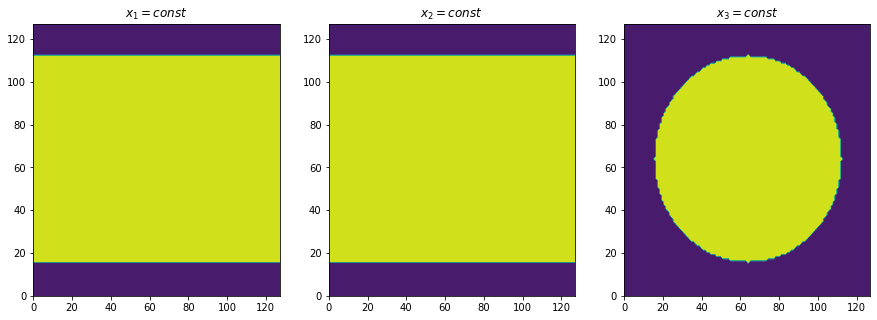

In [25]:
nr=1
nc=len(SIZE)

plt.figure(figsize=(nc*FIGSIZE,nr*FIGSIZE))

plt.subplot(nr,nc,1)
plt.contourf(img[0,slices[0],:,:])
plt.title('$x_1 = const$')

plt.subplot(nr,nc,2)
plt.contourf(img[0,:,slices[1],:])
plt.title('$x_2 = const$')

plt.subplot(nr,nc,3)
plt.contourf(img[0,:,:,slices[2]])
plt.title('$x_3 = const$')

plt.show()

In [26]:
img.min(),img.max()

(tensor(0.), tensor(1.))

## Kinematic properties
The flow rate through a cross-section $x_i = const$ can be expressed as follows:

\begin{equation} 
    \label{eq:flowRate}
    Q_i(x_i) = -\epsilon_{ijk}(\psi_j(x_i,x_k^+) - \psi_j(x_i,x_k^-))l_j,
\end{equation}
where $\epsilon_{ijk}$ is the Levi-Civita symbol, $l_j = (x_j^+ - x_j^-)$.

The array of right-side parts and the matrix of coefficeints. 

In [27]:
#Array of right-side parts
b = np.concatenate((np.zeros(6), np.asarray(Qm + Qp)), axis=0) 

#Matrix of coefficients
Lambda = np.array([[ 1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [ 0, 0, 1,-1, 0, 0, 0, 0, 0, 0, 0, 0],
                   [ 0, 0, 0, 0, 1,-1, 0, 0, 0, 0, 0, 0],
                   [ 0, 0, 0, 0, 0, 0, 1,-1, 0, 0, 0, 0],
                   [ 0, 0, 0, 0, 0, 0, 0, 0, 1,-1, 0, 0],
                   [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,-1],
                   [    0,    0,    0,    0, L[1],-L[1],    0,    0,-L[2], L[2],    0,    0],
                   [-L[0], L[0],    0,    0,    0,    0,    0,    0,-L[2],    0,-L[2],    0],
                   [ L[0],    0,-L[0],    0,-L[1],    0, L[1],    0,    0,    0,    0,    0],
                   [    0,    0,    0,    0,    0,    0, L[1],-L[1],    0,    0,-L[2], L[2]],
                   [    0,    0,-L[0], L[0],    0,    0,    0,    0,    0, L[2],    0,-L[2]],
                   [    0, L[0],    0,-L[0],    0,-L[1],    0, L[1],    0,    0,    0,    0]])

In [28]:
np.linalg.det(Lambda)

0.0

Array of unknowns $y$:
\begin{equation}
    \begin{bmatrix}
    \psi_1^{--}, & \psi_1^{-+}, & \psi_1^{+-}, & \psi_1^{++}, & \psi_2^{--}, & \psi_2^{-+}, & \psi_2^{+-}, & \psi_2^{++}, & \psi_3^{--}, & \psi_3^{-+}, & \psi_3^{+-}, & \psi_3^{++}
    \end{bmatrix}.
\end{equation}

Solution of the system of linear equations $\boldsymbol\Lambda \cdot y = b$. DOESN'T WORK SO FAR

In [29]:
# y = np.linalg.solve(Lambda, b)
# y

$\boldsymbol\Psi$ on borders

In [30]:
psimm = torch.tensor([0, 0, 0])
psipp = torch.tensor([ Qp[2]/(2*L[1] - L[0]), 2*Qp[2]/(2*L[1] - L[0]), 0]) #similar to analytical solution for a pipe

psi_norm = Qp[2]/L[1] # flow between 2 plates
psi_norm, psipp, psimm

(0.000375, tensor([0.0004, 0.0008, 0.0000]), tensor([0, 0, 0]))

$\boldsymbol\Psi$ initialization

In [31]:
#psi1(x_2,x_3)
psi1 = torch.linspace(psimm[0], psipp[0], SIZE[1], dtype=torch.float32)
psi1 = torch.unsqueeze(psi1,1)
psi1 = psi1.expand(-1,SIZE[2])

#psi2(x_1,x_3)
psi2 = torch.linspace(psimm[1], psipp[1], SIZE[0], dtype=torch.float32)
psi2 = torch.unsqueeze(psi2,1)
psi2 = psi2.expand(-1,SIZE[2])

#psi3(x_1,x_2)
psi3 = torch.linspace(psimm[2], psipp[2], SIZE[0], dtype=torch.float32)
psi3 = torch.unsqueeze(psi3,1)
psi3 = psi3.expand(-1,SIZE[1])

psi = [psi1, psi2, psi3]

Convert $\boldsymbol\Psi$ into tensor 3 x 1 x SIZE[0] x SIZE[1]

In [32]:
psi = torch.stack(psi)
psi = torch.unsqueeze(psi,1)
psi.size()

torch.Size([3, 1, 128, 128])

Fix constant values in NL first and last layers and set the boundary conditions (set flow rates)

In [33]:
for i in range(len(SIZE)):
    psi[i,0,:NL,:]  = psimm[i]
    psi[i,0,-NL:,:] = psipp[i]
psi[2,0,:,0] = psimm[2]
psi[2,0,:,-1] = psipp[2]

Visualization

Psi function Visualization


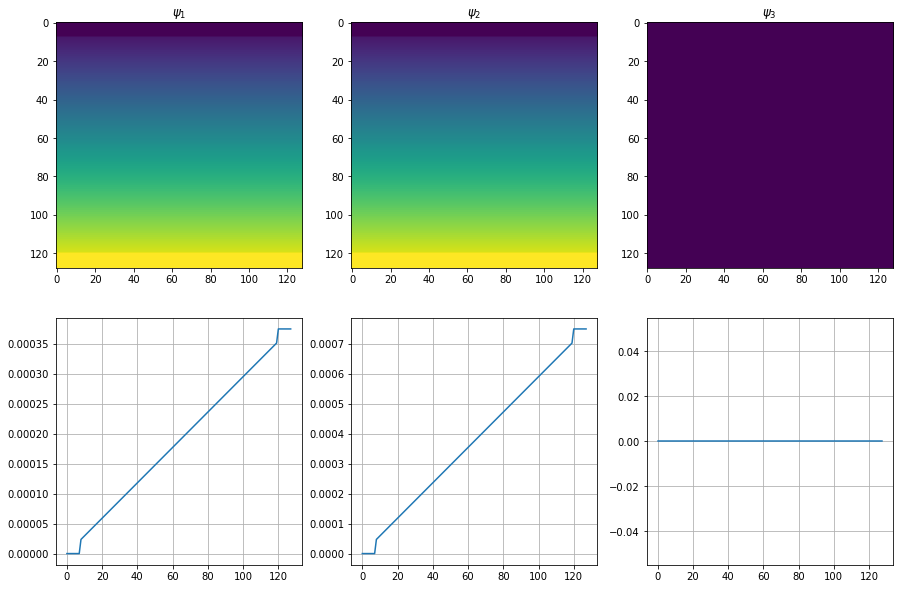

Q1+ = 0.0, target value: 0,
Q2+ = 0.0, target value: 0,
Q3+ = 3.000000106112566e-06, target value: 3e-06

Velocity distribution visualization without flow domain mask (first line) and with mask (second line)


C:\Users\IMS\anaconda3\envs\Pytorch\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


-7.108051036652796e-09 < v_1 < 1.4216102073305592e-08,
-7.108051036652796e-09 < v_2 < 3.554025518326398e-09,
-0.21093857288360596 < v_3 < 0.4218757748603821,
Q1- = 0.0, Q1+ = 2.328306276076775e-13
Q2- = 0.0, Q2+ = -1.1641531380383874e-13
Q3- = 2.9999998787388904e-06, Q3+ = 2.9999998787388904e-06
Vabs[0,0,0] = 0.0, Vabs[0,0,-1] = 0.0, Vabs[0,-1,0] = 4.620232800789381e-07, Vabs[0,-1,-1] = 4.620779634478822e-07, Vabs[-1,0,0] = 9.240465601578762e-07, Vabs[-1,0,-1] = 9.241559268957644e-07, Vabs[-1,-1,0] = 4.620232800789381e-07, Vabs[-1,-1,-1] = 4.622965832368209e-07,


C:\Users\IMS\anaconda3\envs\Pytorch\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\IMS\anaconda3\envs\Pytorch\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


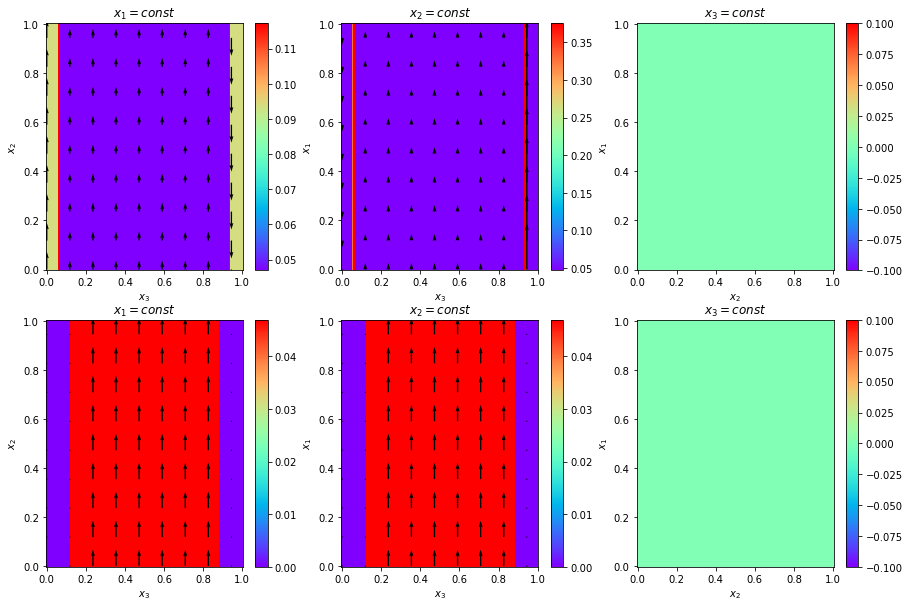

In [34]:
flowVisualization(psi.permute(1,0,2,3))

## Create model
Unet architecture [2] is used

In [35]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)
        self.decoder0 = UNet._block(features, features, name="dec1", use_bn=use_bn)
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec0 = self.decoder0(dec1)
        return self.conv(dec0)*psi_norm #torch.tanh(self.conv(dec0))*psi_abs_limit #torch.sigmoid(self.conv(dec0))*psipp.max()

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                ]
            )
        )

## Loss

In [36]:
def power_loss(psi):
    
    #Fix psi function on the boundaries
    psi_masked = psi.clone()
    for i in range(len(SIZE)):
        psi_masked[i,:,:NL,:]  = psimm[i]
        #psi_masked[i,:,-NL:,:] = psipp[i]
    psi_masked[0,:,-NL:,:] = psi_masked[0,0,-1,-1]
    psi_masked[1,:,-NL:,:] = (Qp[2] + psi_masked[0,0,-1,-1]*L[0]) / L[1]
    
    psi_masked[2,:,-NL:,:] = psipp[2]
    psi_masked[2,0,:,0] = psimm[2]
    psi_masked[2,0,:,-1] = psipp[2]

    v1, v2, v3 = velocityDistr(psi_masked[0,0,:,:], psi_masked[1,0,:,:], psi_masked[2,0,:,:], DX1N, DX2N, DX3N, L[0], L[1], L[2])
    
    xi11, xi12, xi13, xi22, xi23, xi33, EtaEta = TksiDistr(v1, v2, v3, DX1N, DX2N, DX3N, L[0], L[1], L[2])
    
    #Subintegral expression with masks for fluid and walls, respectively:
    subInt = ((0.5*Q0*EtaEta + ((Q1/(Z+1))*EtaEta**((Z+1)*0.5)))*img[0,:,:,:] + 
              (0.5*Q0W*EtaEta + ((Q1W/(ZW+1))*EtaEta**((ZW+1)*0.5)))*(1-img[0,:,:,:])) #+ REG_LOSS_COEF*(Qp[2] + psi_masked[0,0,-1,-1]*L[0] - psi_masked[1,0,-1,-1]*L[1])**2)
#    subInt = 0.5*Q0*EtaEta     
    #Integral
    out = int_func_simpson_3d(subInt, DX1N*L[0], DX2N*L[1], DX3N*L[2])
    
    return out

## Training

In [37]:
start_time = time.time()

hyperparams: 
 Epochs 60000, learning_rate 0.0001, scheduler none, scheduler_factor 0.5, scheduler_patience 3000, use_bn True, Early_stop_patience 60000, Decay 0.0001


Epoch:   0%|          | 0/60000 [00:00<?, ?it/s]

epoch 100/60000, loss = 10.5096
epoch 200/60000, loss = 4.6290
epoch 300/60000, loss = 2.7783
epoch 400/60000, loss = 1.9244
epoch 500/60000, loss = 1.4424
epoch 600/60000, loss = 1.1364
epoch 700/60000, loss = 0.9288
epoch 800/60000, loss = 0.7808
epoch 900/60000, loss = 0.6694
epoch 1000/60000, loss = 0.5824
epoch 1100/60000, loss = 0.5123
epoch 1200/60000, loss = 0.4549
epoch 1300/60000, loss = 0.4072
epoch 1400/60000, loss = 0.3670
epoch 1500/60000, loss = 0.3329
epoch 1600/60000, loss = 0.3036
epoch 1700/60000, loss = 0.2781
epoch 1800/60000, loss = 0.2558
epoch 1900/60000, loss = 0.2362
epoch 2000/60000, loss = 0.2193
epoch 2100/60000, loss = 0.2028
epoch 2200/60000, loss = 0.1898
epoch 2300/60000, loss = 0.1765
epoch 2400/60000, loss = 0.1674
epoch 2500/60000, loss = 0.1541
epoch 2600/60000, loss = 0.1500
epoch 2700/60000, loss = 0.1464
epoch 2800/60000, loss = 0.1379
epoch 2900/60000, loss = 0.5506
epoch 3000/60000, loss = 0.1151
epoch 3100/60000, loss = 0.1138
epoch 3200/60000

epoch 25300/60000, loss = 0.0088
epoch 25400/60000, loss = 0.0050
epoch 25500/60000, loss = 0.0050
epoch 25600/60000, loss = 0.0066
epoch 25700/60000, loss = 0.0050
epoch 25800/60000, loss = 0.0055
epoch 25900/60000, loss = 0.0051
epoch 26000/60000, loss = 0.0047
epoch 26100/60000, loss = 0.0103
epoch 26200/60000, loss = 0.0051
epoch 26300/60000, loss = 0.0046
epoch 26400/60000, loss = 0.0047
epoch 26500/60000, loss = 0.0065
epoch 26600/60000, loss = 0.0045
epoch 26700/60000, loss = 0.0046
epoch 26800/60000, loss = 0.0337
epoch 26900/60000, loss = 0.0048
epoch 27000/60000, loss = 0.0046
epoch 27100/60000, loss = 0.0052
epoch 27200/60000, loss = 0.0054
epoch 27300/60000, loss = 0.0069
epoch 27400/60000, loss = 0.0103
epoch 27500/60000, loss = 0.0050
epoch 27600/60000, loss = 0.0046
epoch 27700/60000, loss = 0.0051
epoch 27800/60000, loss = 0.0043
epoch 27900/60000, loss = 0.0058
epoch 28000/60000, loss = 0.0073
epoch 28100/60000, loss = 0.0097
epoch 28200/60000, loss = 0.1235
epoch 2830

epoch 50200/60000, loss = 0.0034
epoch 50300/60000, loss = 0.0035
epoch 50400/60000, loss = 0.0034
epoch 50500/60000, loss = 0.0038
epoch 50600/60000, loss = 0.0035
epoch 50700/60000, loss = 0.0034
epoch 50800/60000, loss = 0.0035
epoch 50900/60000, loss = 0.0035
epoch 51000/60000, loss = 0.0033
epoch 51100/60000, loss = 0.0033
epoch 51200/60000, loss = 0.0033
epoch 51300/60000, loss = 0.0033
epoch 51400/60000, loss = 0.0035
epoch 51500/60000, loss = 0.0033
epoch 51600/60000, loss = 0.0033
epoch 51700/60000, loss = 0.0037
epoch 51800/60000, loss = 0.0071
epoch 51900/60000, loss = 0.0033
epoch 52000/60000, loss = 0.0038
epoch 52100/60000, loss = 0.0045
epoch 52200/60000, loss = 0.0036
epoch 52300/60000, loss = 0.0039
epoch 52400/60000, loss = 0.0037
epoch 52500/60000, loss = 0.0032
epoch 52600/60000, loss = 0.0035
epoch 52700/60000, loss = 0.0033
epoch 52800/60000, loss = 0.0037
epoch 52900/60000, loss = 0.0056
epoch 53000/60000, loss = 0.0032
epoch 53100/60000, loss = 0.0033
epoch 5320

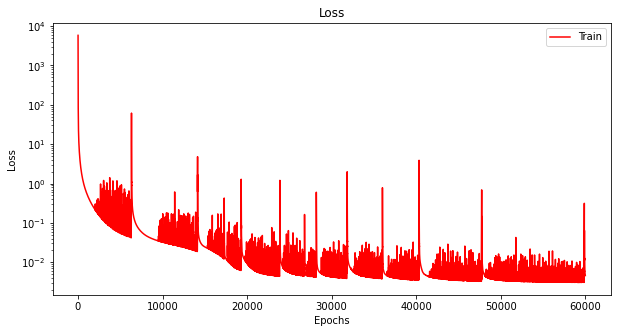

Final loss: 0.003
simulation time:120m 52s


In [38]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

x = psi

# Перемещение на GPU
x = x.to(DEVICE)
dOmega = dOmega.to(DEVICE)

psimm = psimm.to(DEVICE)
psipp = psipp.to(DEVICE)

img = img.to(DEVICE)

DX1N = DX1N.to(DEVICE)
DX2N = DX2N.to(DEVICE)
DX3N = DX3N.to(DEVICE)

run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}.pth')

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]

    model = UNet(in_channels=IN_CH, out_channels=OUT_CH, init_features=NoOfFeatures, use_bn=hyp["use_bn"])
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)
    
    criterion = power_loss
    
    #Log model, criterion, and optimizer
    run["config/model"] = type(model).__name__
    run["config/criterion"] = type(criterion).__name__
    run["config/optimizer"] = type(optimizer).__name__

    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None

    history = train(model, x, optimizer, power_loss,
                    epochs=EPOCHS, print_every=100,
                    callbacks=callbacks, lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric > train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_val_metric, best_hyp))

model = UNet(in_channels=IN_CH, out_channels=OUT_CH, init_features=NoOfFeatures, use_bn=best_hyperparams["use_bn"])
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

psi = model.forward(x)

plot_train_history(best_run['history'])

simulation_time = time.time() - start_time
print(f'Final loss: {power_loss(psi).cpu().item() :.3f}')
print('simulation time:{:.0f}m {:.0f}s'.format(
      simulation_time // 60, simulation_time % 60))

## Results

Download the trained model

In [39]:
# model = UNet(in_channels=IN_CH, out_channels=OUT_CH, init_features=NoOfFeatures, use_bn=best_hyperparams["use_bn"])
# model.load_state_dict(torch.load(best_model_path))
# model.to(DEVICE)

Calculate loss

In [40]:
#Fix psi function on the boundaries
psi_masked = psi.clone().detach()
for i in range(len(SIZE)):
    psi_masked[i,:,:NL,:]  = psimm[i].to('cpu')
    #psi_masked[i,:,-NL:,:] = psipp[i]
psi_masked[0,:,-NL:,:] = psi_masked[0,0,-1,-1]    
psi_masked[1,:,-NL:,:] = (Qp[2] + psi_masked[0,0,-1,-1]*L[0]) / L[1]
    
psi_masked[2,:,-NL:,:] = psipp[2].to('cpu')
psi_masked[2,0,:,0] = psimm[2].to('cpu')
psi_masked[2,0,:,-1] = psipp[2].to('cpu')

v1, v2, v3 = velocityDistr(psi_masked[0,0,:,:], psi_masked[1,0,:,:], psi_masked[2,0,:,:], DX1N, DX2N, DX3N, L[0], L[1], L[2])

dv1dx1, dv2dx2, dv3dx3, divV  = divVel(v1, v2, v3, DX1N, DX2N, DX3N, L[0], L[1], L[2])

V = torch.stack([v1,v2,v3])
Vabs = torch.sqrt(v1**2 + v2**2 + v3**2)
xi11, xi12, xi13, xi22, xi23, xi33, EtaEta = TksiDistr(v1, v2, v3, DX1N, DX2N, DX3N, L[0], L[1], L[2])

#Subintegral expression with masks for fluid and walls, respectively:
subInt = ((0.5*Q0*EtaEta + ((Q1/(Z+1))*EtaEta**((Z+1)*0.5)))*img[0,:,:,:].to(DEVICE) +
          (0.5*Q0W*EtaEta + ((Q1W/(ZW+1))*EtaEta**((ZW+1)*0.5)))*(1-img[0,:,:,:].to(DEVICE))) 
#Integral
int1 = torch.trapz(subInt)
int2 = torch.trapz(int1)
int3 = torch.trapz(int2)
out = int3*dOmega #loss

print(f'absolute velocity: {Vabs.min()} < abs(V) < {Vabs.max()},')
print(f'mean velocity: {Vabs.mean()},')
print(f'internal power: Int = {out},')

absolute velocity: 0.0 < abs(V) < 0.13025052845478058,
mean velocity: 0.046546127647161484,
internal power: Int = 0.003091211197897792,


In [41]:
def mv(f):
    print(f.min())
    print(f.max())
    print(f.mean())

In [42]:
mv(v1[0,:,:])

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Visualization

Psi function Visualization


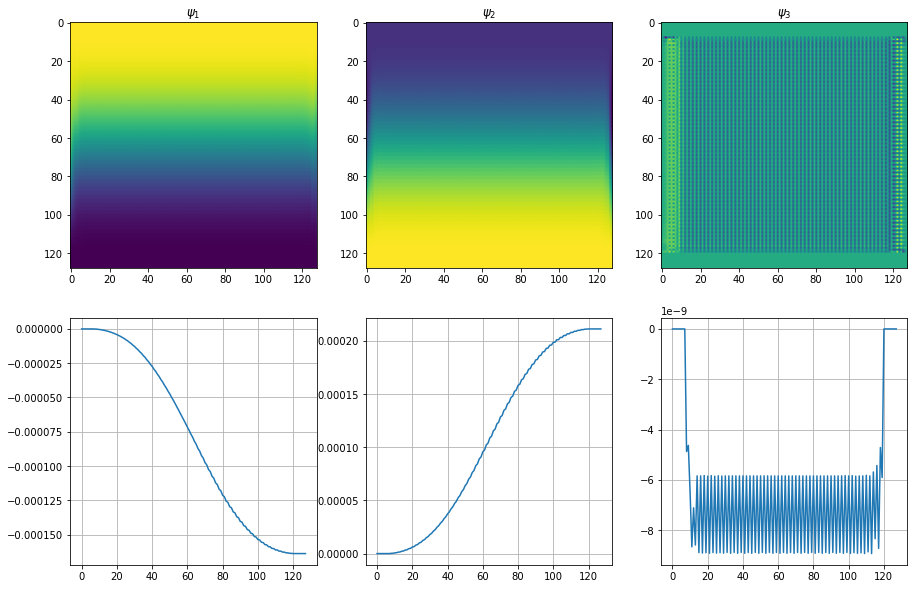

Q1+ = 0.0, target value: 0,
Q2+ = 0.0, target value: 0,
Q3+ = 3.000000106112566e-06, target value: 3e-06

Velocity distribution visualization without flow domain mask (first line) and with mask (second line)
-0.009614307433366776 < v_1 < 0.013114845380187035,
-0.006055449601262808 < v_2 < 0.001355151878669858,
-0.021785380318760872 < v_3 < 0.1299663484096527,
Q1- = 0.0, Q1+ = 2.9103828450959685e-14
Q2- = 0.0, Q2+ = -2.9103828450959685e-14
Q3- = 2.9999998787388904e-06, Q3+ = 2.999999651365215e-06
Vabs[0,0,0] = 0.0, Vabs[0,0,-1] = 0.0, Vabs[0,-1,0] = 1.1550582001973453e-07, Vabs[0,-1,-1] = 1.1551949086197055e-07, Vabs[-1,0,0] = 1.1550582001973453e-07, Vabs[-1,0,-1] = 1.1551949086197055e-07, Vabs[-1,-1,0] = 0.0, Vabs[-1,-1,-1] = 2.513075525456543e-09,


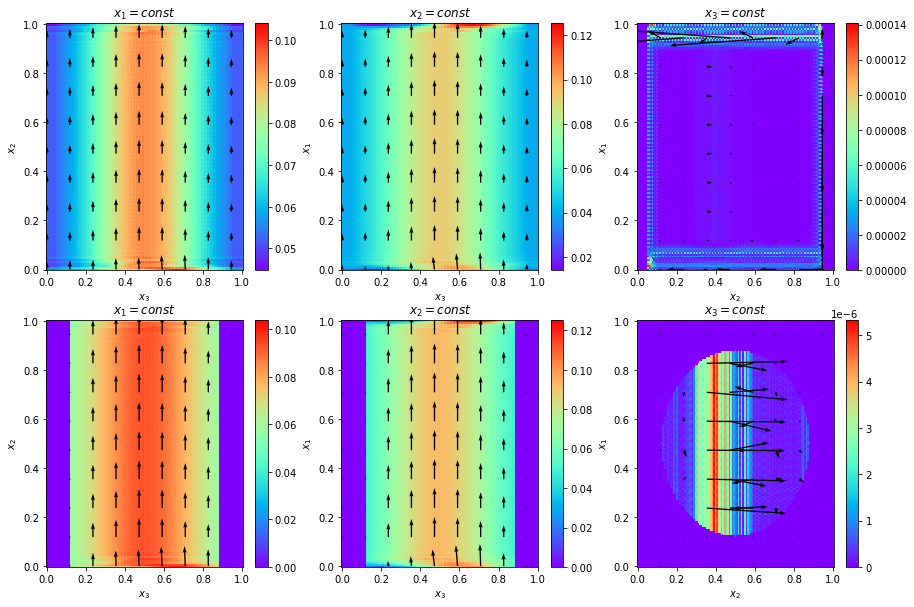

In [43]:
flowVisualization(psi_masked.permute(1,0,2,3))

Maximum velocity value in a slice

In [44]:
v3max = v3[slices[0],:,slices[2]].max()
v3max

tensor(0.0935, device='cuda:0')

Mean velocity in the flow domain

In [45]:
vabsmean = Vabs.mean()
vabsmean

tensor(0.0465, device='cuda:0')

torch.Size([128, 128, 128, 3])


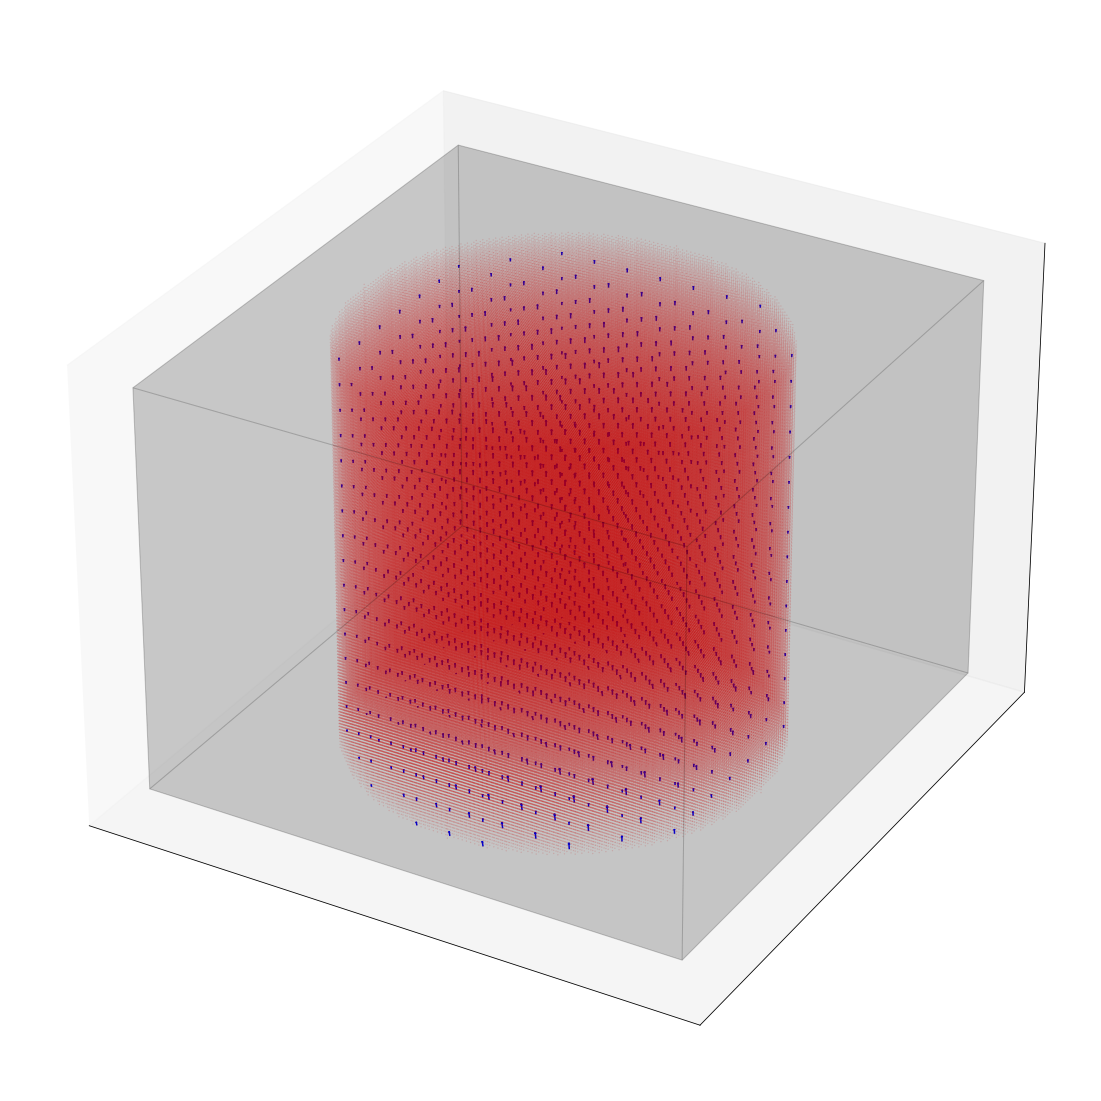

In [46]:
x = np.meshgrid(np.arange(0, SIZE[0], STEP3D),
                np.arange(0, SIZE[1], STEP3D),
                np.arange(0, SIZE[2], STEP3D))
v_all = torch.stack((v1.cpu() * img[0].cpu(), v2.cpu() * img[0].cpu(), v3.cpu() * img[0].cpu()), 3)
v_abs = torch.sqrt(v_all[:, :, :, 0]**2 + v_all[:, :, :, 1]**2 + v_all[:, :, :, 2]**2)
print(v_all.size())
vector_plot_3d(x, v_all.cpu().detach().rot90(), v_abs.rot90(), figSize=FIGSIZE*4, step = STEP3D)

## Log results

In [47]:
results = {'Loss':out,
           'abs(V).min':Vabs.min(),
           'abs(V).max':Vabs.max(),
           'abs(V).mean':Vabs.mean(),
           
           }
run["config/results"] = results

## Stop logging

In [48]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/avkornaev/PhysicsBasedDL/e/PHYSIC-242


# Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch